In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_gu = '송파구'
target_dong = '석촌동'
#target_purpose = '준주거'
target_building_age = 3
target_period = 36 # in months

In [3]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [4]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210621'

In [5]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [6]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [7]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [8]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01,  9.39it/s]


(638984, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [9]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 31.73it/s]


(181572, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [10]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(820556, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,34.47,31000,4,2015.0,1.0,2016-03-01,899.332753,6.0,연립다세대
4,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,34.47,30000,3,2015.0,1.0,2016-03-20,870.322019,6.0,연립다세대


In [11]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [12]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [13]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [14]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [15]:
target_df = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(158, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
578691,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,28.905,30000,5,2018.0,1.0,2019-10-04,1037.882719,3.0,연립다세대,송파구,석촌동
578692,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,38.925,38000,4,2018.0,0.0,2018-11-20,976.236352,3.0,연립다세대,송파구,석촌동
578693,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,38.925,38000,4,2018.0,1.0,2019-01-20,976.236352,3.0,연립다세대,송파구,석촌동
578694,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,48.525,28500,1,2018.0,0.0,2018-11-21,587.326121,3.0,연립다세대,송파구,석촌동
578695,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,50.210,43000,2,2018.0,2.0,2020-01-14,856.403107,3.0,연립다세대,송파구,석촌동


In [16]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [17]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [18]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [19]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(158, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
578691,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,28.905,30000,5,2018.0,1.0,2019-10-04,1037.882719,3.0,연립다세대,송파구,석촌동,1203.637828,2021-04-01
578692,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,38.925,38000,4,2018.0,0.0,2018-11-20,976.236352,3.0,연립다세대,송파구,석촌동,1182.837567,2021-04-01
578693,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,38.925,38000,4,2018.0,1.0,2019-01-20,976.236352,3.0,연립다세대,송파구,석촌동,1188.811036,2021-04-01
578694,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,48.525,28500,1,2018.0,0.0,2018-11-21,587.326121,3.0,연립다세대,송파구,석촌동,711.622138,2021-04-01
578695,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,50.210,43000,2,2018.0,2.0,2020-01-14,856.403107,3.0,연립다세대,송파구,석촌동,990.084859,2021-04-01


In [20]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [21]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,층,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 송파구 석촌동 150-18,엘리움파크,3.0,4,38.925,2018-11-20,38000,976.236352,2021-04-01,1182.837567,연립다세대
1,서울특별시 송파구 석촌동 150-18,엘리움파크,3.0,1,48.525,2018-11-21,28500,587.326121,2021-04-01,711.622138,연립다세대
2,서울특별시 송파구 석촌동 150-18,엘리움파크,3.0,4,38.925,2019-01-20,38000,976.236352,2021-04-01,1188.811036,연립다세대
3,서울특별시 송파구 석촌동 150-18,엘리움파크,3.0,5,28.905,2019-10-04,30000,1037.882719,2021-04-01,1203.637828,연립다세대
4,서울특별시 송파구 석촌동 150-18,엘리움파크,3.0,2,50.210,2020-01-14,43000,856.403107,2021-04-01,990.084859,연립다세대


In [22]:
target_df1_30 = target_df1[
    (target_df1['전용면적(㎡)'] >= 28)
    &(target_df1['전용면적(㎡)'] <= 32)
]

In [23]:
target_df1_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

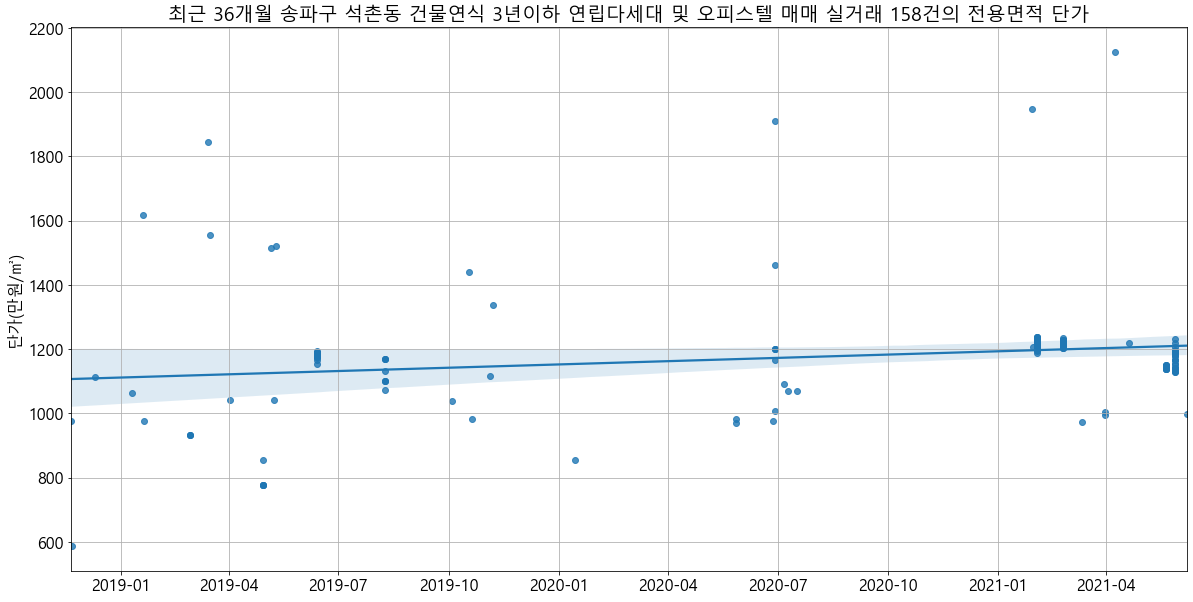

In [24]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [25]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

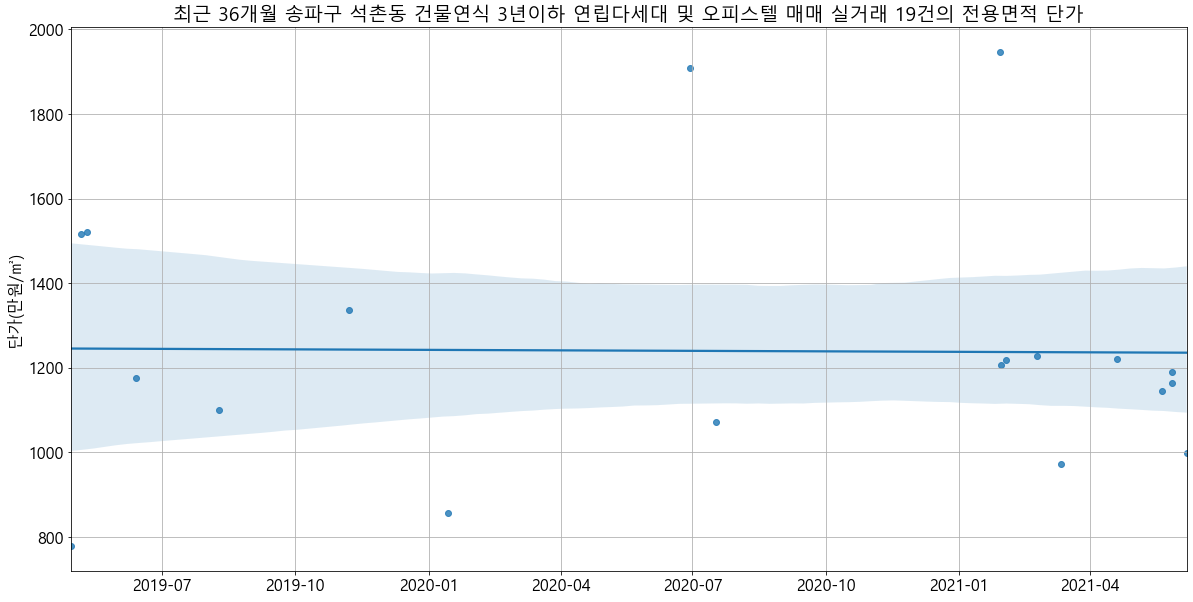

In [26]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [27]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [28]:
target_df2 = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(995, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
578629,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,19.54,21200,5,2015.0,0.0,2015-03-26,1084.953941,6.0,연립다세대,송파구,석촌동
578630,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,27.50,31200,4,2015.0,0.0,2015-03-26,1134.545455,6.0,연립다세대,송파구,석촌동
578631,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,41.54,32000,5,2015.0,0.0,2015-03-20,770.341839,6.0,연립다세대,송파구,석촌동
578632,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.51,35800,3,2015.0,0.0,2015-02-11,723.086245,6.0,연립다세대,송파구,석촌동
578633,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.51,35500,4,2015.0,0.0,2015-03-05,717.026863,6.0,연립다세대,송파구,석촌동


In [29]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'송파구 석촌동 계약날짜기준 건물연식 3년이하 연립다세대 및 오피스텔 매매 실거래 995건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

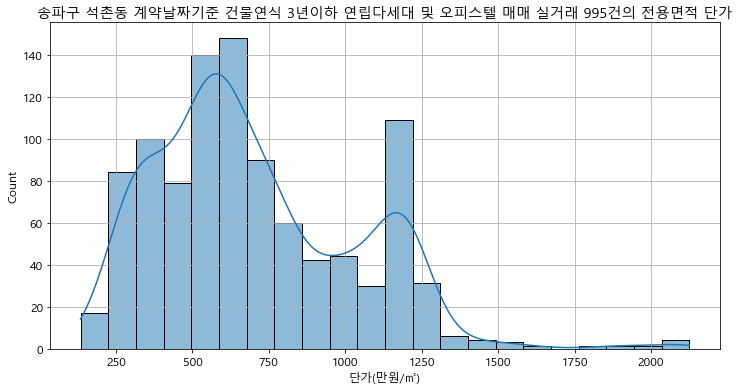

In [30]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [31]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [32]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [33]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [34]:
concat_df = pd.concat([target_df2])

In [35]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [36]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [37]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(547, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,19.54,21200,5,2015.0,0.0,2015-03-26,1084.953941,6.0,연립다세대,송파구,석촌동,1568.374800,2021-04-01,879.782856,1269.528902
1,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,27.50,31200,4,2015.0,0.0,2015-03-26,1134.545455,6.0,연립다세대,송파구,석촌동,1640.062710,2021-04-01,879.782856,1269.528902
2,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,41.54,32000,5,2015.0,0.0,2015-03-20,770.341839,6.0,연립다세대,송파구,석촌동,1113.581584,2021-04-01,879.782856,1269.528902
3,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.51,35900,2,2015.0,0.0,2015-03-27,725.106039,6.0,연립다세대,송파구,석촌동,1048.190155,2021-04-01,879.782856,1269.528902
4,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.71,34000,3,2015.0,0.0,2015-06-08,683.967009,6.0,연립다세대,송파구,석촌동,977.435259,2021-04-01,879.782856,1269.528902


In [38]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(169, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
4,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.710,34000,3,2015.0,0.0,2015-06-08,683.967009,6.0,연립다세대,송파구,석촌동,977.435259,2021-04-01,879.782856,1269.528902
5,서울특별시 송파구 석촌동 13-15,백제고분로33길 3-10,그린빌(13-15),41.400,13000,2,2004.0,2.0,2006-11-02,314.009662,17.0,연립다세대,송파구,석촌동,618.551965,2021-04-01,314.009662,618.551965
9,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),103.490,36500,5,2006.0,0.0,2006-11-22,352.691081,15.0,연립다세대,송파구,석촌동,694.748563,2021-04-01,333.682004,657.303530
13,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,50.210,43000,2,2018.0,2.0,2020-01-14,856.403107,3.0,연립다세대,송파구,석촌동,990.084859,2021-04-01,864.462075,1023.538965
17,서울특별시 송파구 석촌동 150-8,백제고분로36가길 19-8,이수빌,63.880,32000,2,2008.0,2.0,2010-03-11,500.939261,13.0,연립다세대,송파구,석촌동,667.105324,2021-04-01,566.649252,772.954189
18,서울특별시 송파구 석촌동 154-4,석촌호수로18길 19-7,(154-4),44.385,23500,3,2014.0,0.0,2014-07-18,529.458150,7.0,연립다세대,송파구,석촌동,790.250803,2021-04-01,529.458150,790.250803
19,서울특별시 송파구 석촌동 16-11,삼학사로14길 18,(16-11),52.440,30000,5,2009.0,1.0,2010-12-14,572.082380,12.0,연립다세대,송파구,석촌동,792.691308,2021-04-01,572.082380,792.691308
27,서울특별시 송파구 석촌동 163-10,백제고분로39길 29-15,(163-10),104.280,26000,5,2004.0,2.0,2006-01-20,249.328730,17.0,연립다세대,송파구,석촌동,630.651813,2021-04-01,288.288934,729.197708
32,서울특별시 송파구 석촌동 163-4,백제고분로39길 25-16,잠실빌리지,43.220,42500,2,2018.0,1.0,2019-10-20,983.341046,3.0,연립다세대,송파구,석촌동,1140.385574,2021-04-01,1418.433154,1649.311039
33,서울특별시 송파구 석촌동 164-21,백제고분로37가길 17,해피빌투,55.320,20400,2,2004.0,2.0,2006-12-13,368.763557,17.0,연립다세대,송파구,석촌동,712.839663,2021-04-01,368.763557,712.839663


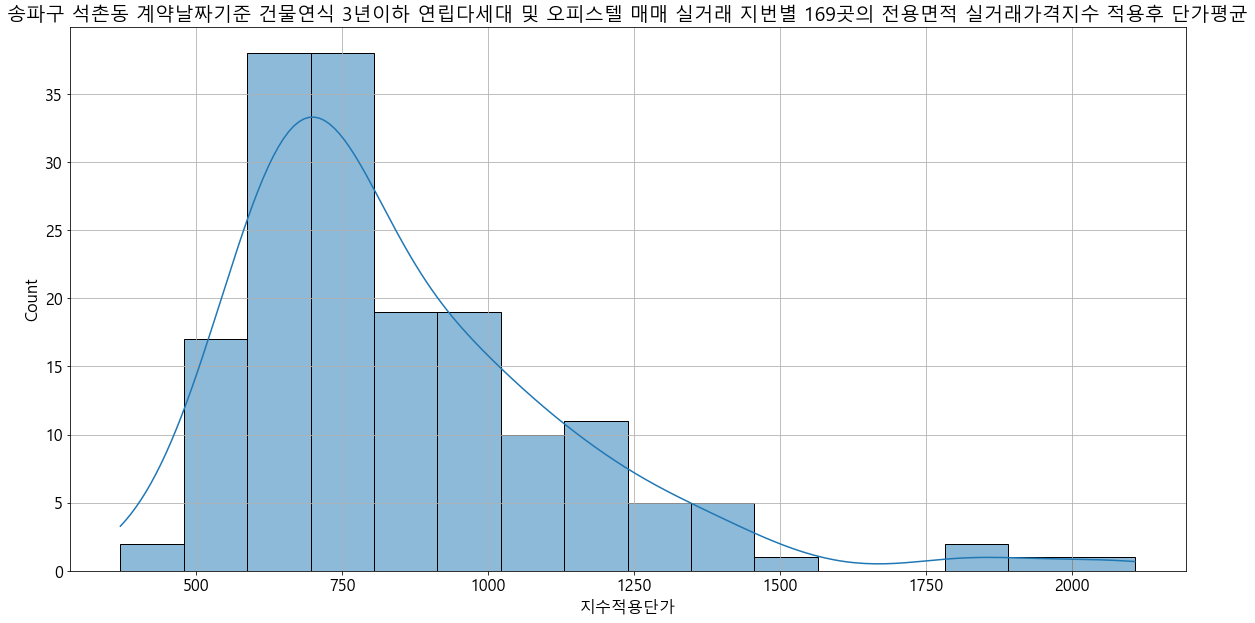

In [39]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [40]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [41]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 송파구 석촌동 12-15,뮤지컬파크,2015.0,49.71,3,2015-06-08,683.967009,2021-04-01,977.435259,연립다세대
1,서울특별시 송파구 석촌동 13-15,그린빌(13-15),2004.0,41.40,2,2006-11-02,314.009662,2021-04-01,618.551965,연립다세대
2,서울특별시 송파구 석촌동 150-0,(150-0),2006.0,103.49,5,2006-11-22,352.691081,2021-04-01,694.748563,연립다세대
3,서울특별시 송파구 석촌동 150-18,엘리움파크,2018.0,50.21,2,2020-01-14,856.403107,2021-04-01,990.084859,연립다세대
4,서울특별시 송파구 석촌동 150-8,이수빌,2008.0,63.88,2,2010-03-11,500.939261,2021-04-01,667.105324,연립다세대


In [42]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)